$$\nabla \cdot (q(\textbf{u}) \nabla \textbf{u})=f \in \Omega $$ 

$$\textbf{u}=\textbf{u}_D \in \partial \Omega $$ 

$$q(u)=1+u^2$$

In [119]:
import ufl
import numpy
import numpy as np

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import mesh, fem, io, nls, log,default_scalar_type
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver

def q(u):
    return u**2
    #return ufl.exp(-1*((u-0.5)^2)/0.5)


domain = mesh.create_unit_square(MPI.COMM_WORLD, 50, 50)
x = ufl.SpatialCoordinate(domain)
u_ufl = 1 + x[0] + 2 * x[1]
h = - ufl.div(q(u_ufl) * ufl.grad(u_ufl))

V = fem.functionspace(domain, ("Lagrange", 1))
def u_exact(x): return eval(str(u_ufl))

# Boundary conditions
u_D = fem.Function(V)
u_D.interpolate(u_exact)
fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, lambda x: numpy.full(x.shape[1], True, dtype=bool))
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets))


f = fem.Constant(domain, default_scalar_type(-6))


[2025-05-25 00:29:30.399] [info] Extract basic topology: 15000->15000
[2025-05-25 00:29:30.399] [info] Build local dual graph
[2025-05-25 00:29:30.399] [info] Build local part of mesh dual graph (mixed)
[2025-05-25 00:29:30.401] [info] GPS pseudo-diameter:(198) 4901-98
[2025-05-25 00:29:30.401] [info] Create topology (single cell type)
[2025-05-25 00:29:30.401] [info] Create topology (generalised)
[2025-05-25 00:29:30.402] [info] Computing communication graph edges (using NBX algorithm). Number of input edges: 1
[2025-05-25 00:29:30.402] [info] Finished graph edge discovery using NBX algorithm. Number of discovered edges 1
[2025-05-25 00:29:30.402] [info] Compute ghost indices
[2025-05-25 00:29:30.402] [info] Computing communication graph edges (using PCX algorithm). Number of input edges: 0
[2025-05-25 00:29:30.402] [info] Finished graph edge discovery using PCX algorithm. Number of discovered edges 0
[2025-05-25 00:29:30.404] [info] Computing communication graph edges (using NBX algo


$$F = q(\textbf{u}) \langle \nabla \textbf{u}, \nabla \textbf{v} \rangle_\Omega - \langle f , v \rangle_\Omega - \langle h,v\rangle_{\Gamma_{N}} dx $$

$$ f = - \nabla (q(\textbf{u}) \nabla \textbf{u})

In [120]:
# Non-linear function
uh = fem.Function(V)
v = ufl.TestFunction(V)
F = q(uh) * ufl.dot(ufl.grad(uh), ufl.grad(v)) * ufl.dx - h * v * ufl.dx - f*v*ufl.dx

In [121]:
problem = NonlinearProblem(F, uh, bcs=[bc])


In [122]:
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

[2025-05-25 00:29:30.521] [info] Column ghost size increased from 0 to 0


In [123]:
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "gmres"
opts[f"{option_prefix}ksp_rtol"] = 1.0e-8
opts[f"{option_prefix}pc_type"] = "hypre"
opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
opts[f"{option_prefix}pc_hypre_boomeramg_max_iter"] = 1
opts[f"{option_prefix}pc_hypre_boomeramg_cycle_type"] = "v"
ksp.setFromOptions()

In [124]:
log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(uh)
assert (converged)
print(f"Number of interations: {n:d}")

[2025-05-25 00:29:30.646] [info] PETSc Krylov solver starting to solve system.
[2025-05-25 00:29:30.651] [info] PETSc Krylov solver starting to solve system.
[2025-05-25 00:29:30.654] [info] Newton iteration 2: r (abs) = 6210.47180870577 (tol = 1e-10), r (rel) = 165.000647227842 (tol = 1e-06)
[2025-05-25 00:29:30.657] [info] PETSc Krylov solver starting to solve system.
[2025-05-25 00:29:30.663] [info] Newton iteration 3: r (abs) = 2070.242851884805 (tol = 1e-10), r (rel) = 55.00248950505938 (tol = 1e-06)
[2025-05-25 00:29:30.665] [info] PETSc Krylov solver starting to solve system.
[2025-05-25 00:29:30.671] [info] Newton iteration 4: r (abs) = 4264.280312546215 (tol = 1e-10), r (rel) = 113.29397076479094 (tol = 1e-06)
[2025-05-25 00:29:30.673] [info] PETSc Krylov solver starting to solve system.
[2025-05-25 00:29:30.711] [info] Newton iteration 5: r (abs) = 1629.605517263047 (tol = 1e-10), r (rel) = 43.29557775265055 (tol = 1e-06)
[2025-05-25 00:29:30.714] [info] PETSc Krylov solver s

In [125]:
import pyvista
tdim = domain.topology.dim
fdim = tdim - 1
print(pyvista.global_theme.jupyter_backend)

from dolfinx import plot
pyvista.start_xvfb()
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)



trame
[2025-05-25 00:30:14.722] [info] Requesting connectivity (2, 0) - (2, 0)


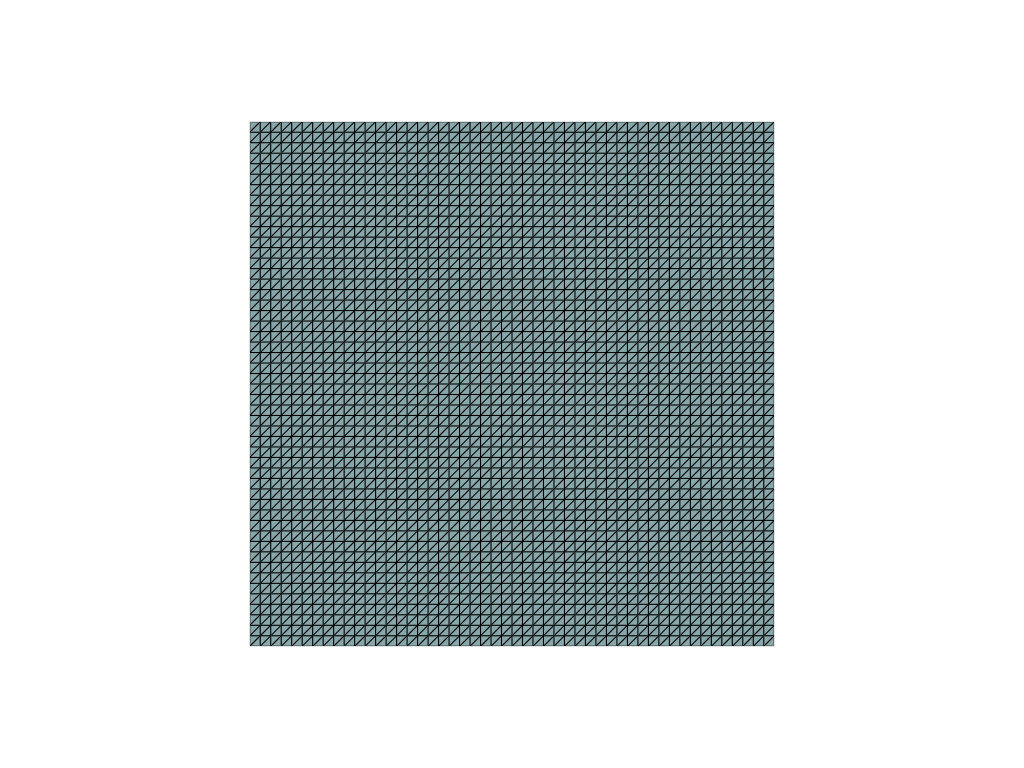

In [126]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

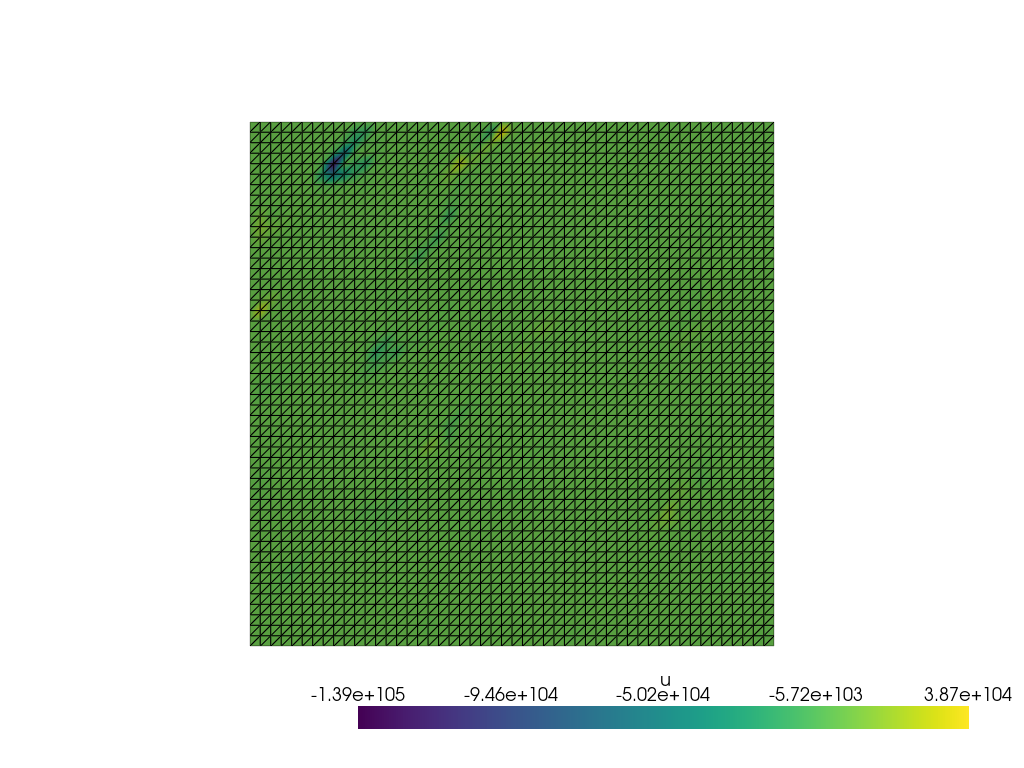

In [127]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()